In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Загружаем ряд

In [2]:
# x = pd.read_excel("data.xlsx").to_numpy().reshape(-1)
x = pd.read_csv("Apple 2000 2022.csv")["Цена open"].dropna().to_numpy()[::-1]
x

array([  3.74,   3.86,   3.7 , ..., 141.24, 145.82, 148.97])

In [3]:
x_train, x_test = train_test_split(x, test_size= 100, shuffle= False)
x_train.shape, x_test.shape

((5605,), (100,))

## Преобразуем в матрицу Хенкеля

In [4]:
L = 200 # windows size
N = x_train.shape[0] # number of elements in x
K = N - L + 1 # number of elements in row

In [5]:
# class SSA:
#
#     @staticmethod
#     def x_to_Hankelian(x, L, K):
#         """
#         :param x: initial times series
#         :param L: window size
#         :param K: number of elements in rows
#         :return: trajectory matrix (sometimes it is called Hankel's matrix of Hankelian)
#         """
#         X = np.zeros((L, K))
#         for i in range(L):
#             X[i] = x[i: i + K]
#         return X
#
#     @staticmethod
#     def Hankelian_to_TS(X):
#         """
#         :param X: Gets matrix (L, K)
#         :return: times series, computed by means of anti-diagonals
#         """
#         X = X[::-1]
#         X = np.array([X.diagonal(i).mean() for i in range(-X.shape[0] + 1, X.shape[1])])
#         return X
#
#     @staticmethod
#     def get_elementry_matrix(s, u, v):
#         """
#         :param s: j-th singular value
#         :param u: j-th vector in U
#         :param v: j-th vector in V
#         :return: evelementary matrix
#         """
#         return s * np.outer(u, v)
#
#     @staticmethod
#     def get_contribution(Sigma):
#         """
#         :param Sigma: vector of singular values
#         :return: (contribution of each eigen value = (singular value) ** 2, cumulative contribution)
#         """
#         Sigma = np.power(Sigma, 2)
#         tmp = Sigma / Sigma.sum()
#         return tmp, tmp.cumsum()
#
#     @staticmethod
#     def get_W_corr_matrix(x_hat, d, K, L):
#         """
#         :param x_hat: reconstructed parts of the time series
#         :param d: rank of matrix X (number of non-zero singular values)
#         :param K: K = N - L + 1
#         :param L: window size
#         :return: matrix of weighted correlation between reconstructed vectors.
#             $${
#                 WCorr_{i, j} = \frac{\left(\hat{x}_i, \hat{x}_j \right)_w}{\sqrt{\lVert \hat{x}_j \rVert_w \cdot \lVert \hat{x}_i \rVert_w} }: \lVert \hat{x}_i \rVert_w =  \left(\hat{x}_i, \hat{x}_i \right)_w = \sum_{k = 1}^K w_k \cdot \hat{x}_{i,k} \cdot \hat{x}_{i,k}
#             }$$
#         """
#         # vector of weights (number of which each element in initial TS x meets in X)
#         w = np.array(list(np.arange(L) + 1) + [L] * (K - 1 - L) + list(np.arange(L) + 1)[::-1])
#         def w_dot_product(a, b, w= w):
#             return np.sum(w * a * b)
#
#         W_corr = np.zeros((d, d))
#         for i in range(L):
#             for j in range(i, L):
#                 enumerator = w_dot_product(x_hat[i], x_hat[j], w)
#                 denominator = (w_dot_product(x_hat[i], x_hat[i], w) * w_dot_product(x_hat[j], x_hat[j], w))**(0.5)
#                 W_corr[i, j] =  enumerator / denominator
#                 W_corr[j, i] = W_corr[i, j]
#
#         return W_corr
#
#     @staticmethod
#     def plot_W_corr(W_corr):
#         """
#         :param W_corr: correlation matrix of reconstructed components
#         :return: Nothing. Plots color map of correlation.
#         """
#         plt.figure(figsize= (18, 9))
#         axis = plt.imshow(W_corr)
#         plt.colorbar(axis.colorbar);
#
#     @staticmethod
#     def plot_x_hat(x_hat, x):
#         """
#         :param x_hat: reconstructed TS in decomposed view
#         :param x: initial TS
#         :return: Nothing. Plots all x_hat and x
#         """
#         plt.figure(figsize= (18, 7))
#         for i in range(x_hat.shape[0]):
#             plt.plot(x_hat[i], label= f"Component: {i}")
#
#         plt.plot(x, label= "True series", alpha= 0.5)
#         plt.legend(loc= "best")
#         plt.grid(True)
#         plt.show()
#
#     @staticmethod
#     def plot_contribution(sigma_contribution):
#         """
#         :param sigma_contribution: (normed to 1 contribution of each singular value, cumsum of normed contribution)
#         :return: Nothing. Plots 2 figures (Singular contribution, Cumsum of singular contribution)
#         """
#         fig, axis = plt.subplots(nrows= 1, ncols= 2, figsize= (18, 5))
#         axis[0].set_title("Contribution")
#         axis[0].plot(sigma_contribution[0])
#         axis[0].scatter(list(np.arange(len(sigma_contribution[0]))), sigma_contribution[0])
#         axis[0].grid(True)
#
#         axis[1].set_title("Cumulative Contribution")
#         axis[1].plot(sigma_contribution[1])
#         axis[1].scatter(list(np.arange(len(sigma_contribution[1]))), sigma_contribution[1])
#         axis[1].grid(True)
#
#         plt.show()
#
#     @staticmethod # Спросить о правильности!!!!!
#     def forecast(Q, reconstructed_values, r, U, N):
#         """
#         :param Q: steps to forecast
#         :param reconstructed_values: reconstruction of initial TS
#         :param r: number of non-zero singular values
#         :param U: orthonormal matrix in SVD decomposition (left side) U Sigma V^T
#         :param N: length of initial TS
#         :return: np.array() -> shape (Q,) - forecast
#         """
#         U_underline = U[:, 0:r]
#         verticality_coef = np.power(U_underline[-1, :], 2).sum()
#         R = np.sum(U_underline[-1, :] * U_underline[0:-1, :], axis= 1) / (1 - verticality_coef)
#         R = R[::-1]
#
#         for i in range(N, N + Q):
#             s = 0
#             for j in range(L - 1):
#                 s += (R[j] * reconstructed_values[i - j - 1])
#             reconstructed_values.append(s)
#
#         forecasted = np.array(reconstructed_values[N:])
#         return forecasted
#
#     @staticmethod
#     def plot_prediction(reconstructed_values, forecasted, x):
#
#         plt.figure(figsize= (18, 8))
#         plt.plot(np.concatenate([np.array(reconstructed_values), forecasted], axis= 0), label= "Reconstruction + forecast", c= "orange")
#         plt.plot(np.arange(len(x)),x, label= "Initial x")
#         plt.legend(loc= "best")
#         plt.grid(True)
#         plt.show()
#
from SSA import SSA

$${
    \text{W_Corr}_{i, j} = \frac{\left(\hat{x}_i, \hat{x}_j \right)_w}{\sqrt{\lVert \hat{x}_j \rVert_w \cdot \lVert \hat{x}_i \rVert_w} }: \lVert \hat{x}_i \rVert_w =  \left(\hat{x}_i, \hat{x}_i \right)_w = \sum_{k = 1}^K w_k \cdot \hat{x}_{i,k} \cdot \hat{x}_{i,k}
}$$

In [6]:
X_train = SSA.x_to_Hankelian(x_train, L, K)
d = np.linalg.matrix_rank(X_train)
U, Sigma, Vt = np.linalg.svd(X_train)
V = Vt.T

contribution = SSA.get_contribution(Sigma)
X_elem = np.array([SSA.get_elementry_matrix(Sigma[i], U[:, i], V[:, i]) for i in range(U.shape[1])])
x_hat = np.array([SSA.Hankelian_to_TS(X_elem[i]) for i in range(X_elem.shape[0])])
W_corr = SSA.get_W_corr_matrix(x_hat, d, K, L)

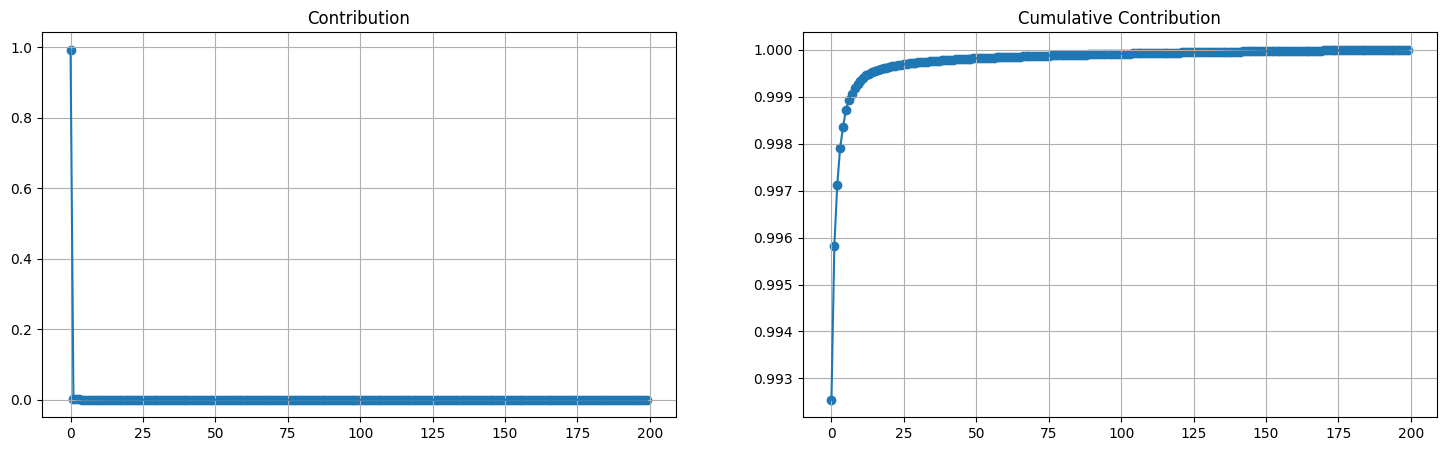

In [7]:
SSA.plot_contribution(SSA.get_contribution(Sigma));

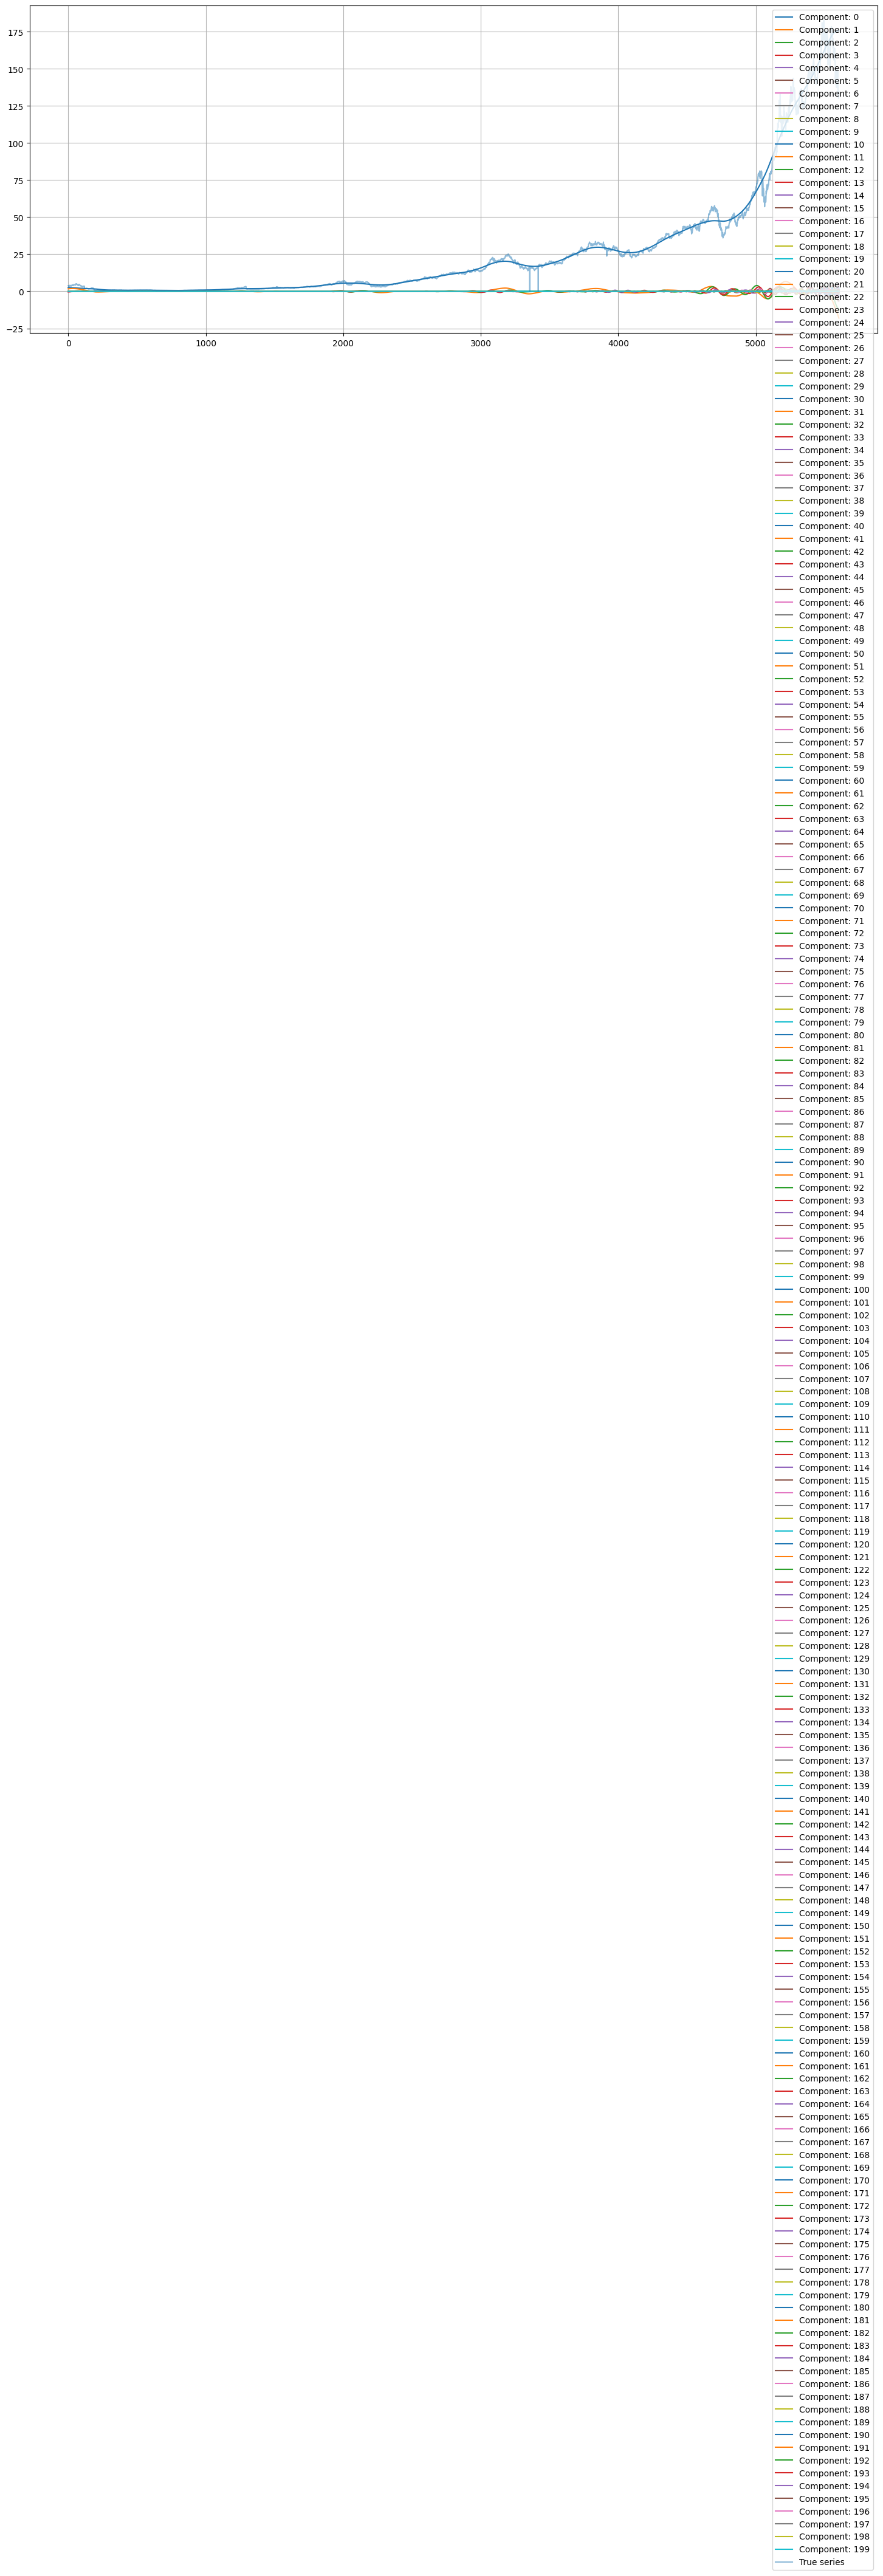

In [8]:
SSA.plot_x_hat(x_hat, x_train);

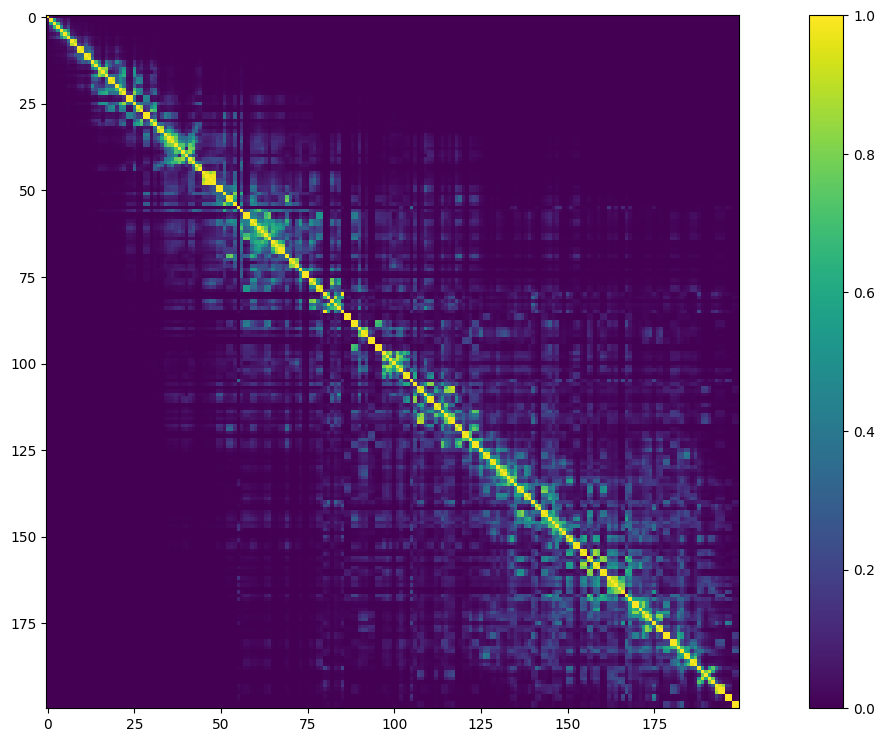

In [9]:
SSA.plot_W_corr(W_corr);

In [62]:
contribution = SSA.get_contribution(Sigma)

# Один из основных параметров: округление до какого знака у сингулярного числа
# Влияет на # элементраных матриц, используемых для реконструкции ряда.

round_number = 6
r = len(contribution[0].round(round_number)[contribution[0].round(round_number) > 0])
r = 104

contribution[0].round(round_number), r

(array([9.92545e-01, 3.28400e-03, 1.29000e-03, 7.94000e-04, 4.41000e-04,
        3.73000e-04, 2.13000e-04, 1.27000e-04, 1.17000e-04, 8.40000e-05,
        7.70000e-05, 5.90000e-05, 5.00000e-05, 3.50000e-05, 3.00000e-05,
        2.40000e-05, 2.20000e-05, 2.10000e-05, 1.80000e-05, 1.70000e-05,
        1.40000e-05, 1.20000e-05, 1.20000e-05, 1.10000e-05, 1.10000e-05,
        1.00000e-05, 8.00000e-06, 8.00000e-06, 8.00000e-06, 8.00000e-06,
        7.00000e-06, 7.00000e-06, 6.00000e-06, 6.00000e-06, 5.00000e-06,
        5.00000e-06, 5.00000e-06, 5.00000e-06, 4.00000e-06, 4.00000e-06,
        4.00000e-06, 4.00000e-06, 4.00000e-06, 4.00000e-06, 4.00000e-06,
        4.00000e-06, 3.00000e-06, 3.00000e-06, 3.00000e-06, 3.00000e-06,
        3.00000e-06, 3.00000e-06, 3.00000e-06, 3.00000e-06, 3.00000e-06,
        3.00000e-06, 3.00000e-06, 2.00000e-06, 2.00000e-06, 2.00000e-06,
        2.00000e-06, 2.00000e-06, 2.00000e-06, 2.00000e-06, 2.00000e-06,
        2.00000e-06, 2.00000e-06, 2.00000e-06, 2.00

In [63]:
Q = 100

# reconstructed series without noise
components_to_use = np.arange(r)
reconstructed_values = list(x_hat[components_to_use].sum(axis= 0))
forecasted = SSA.forecast(Q, reconstructed_values, r, U, N, L)

array([139.77710706, 142.3662012 , 147.59015604, 148.71148301,
       148.9594628 , 147.27573995, 149.95614456, 146.14597518,
       152.76072427, 153.01226838, 155.99191404, 149.83624761,
       149.20482682, 151.45200274, 151.20036927, 148.20626344,
       155.18124429, 162.00077382, 165.34285861, 162.18987501,
       167.68235405, 169.09982351, 165.08076485, 164.1217843 ,
       159.36539743, 156.14481884, 162.08458685, 163.22911922,
       161.67765548, 160.33795903, 165.09790602, 159.81202358,
       162.62636476, 159.78550747, 154.50266684, 153.87317612,
       170.56429329, 171.00355343, 170.26974717, 161.29325723,
       171.43602757, 165.00342659, 167.70745322, 164.4423186 ,
       165.67411292, 161.46421463, 166.99307425, 160.42693754,
       168.94569321, 169.48683673, 172.15759936, 160.58991801,
       158.69342745, 152.64146669, 153.92729104, 159.51763809,
       163.18686667, 154.33484182, 157.52145962, 159.07419072,
       160.14572915, 151.87280709, 159.17934443, 160.03

In [64]:
# SSA.plot_prediction(reconstructed_values[5400:], forecasted, x[5400:])

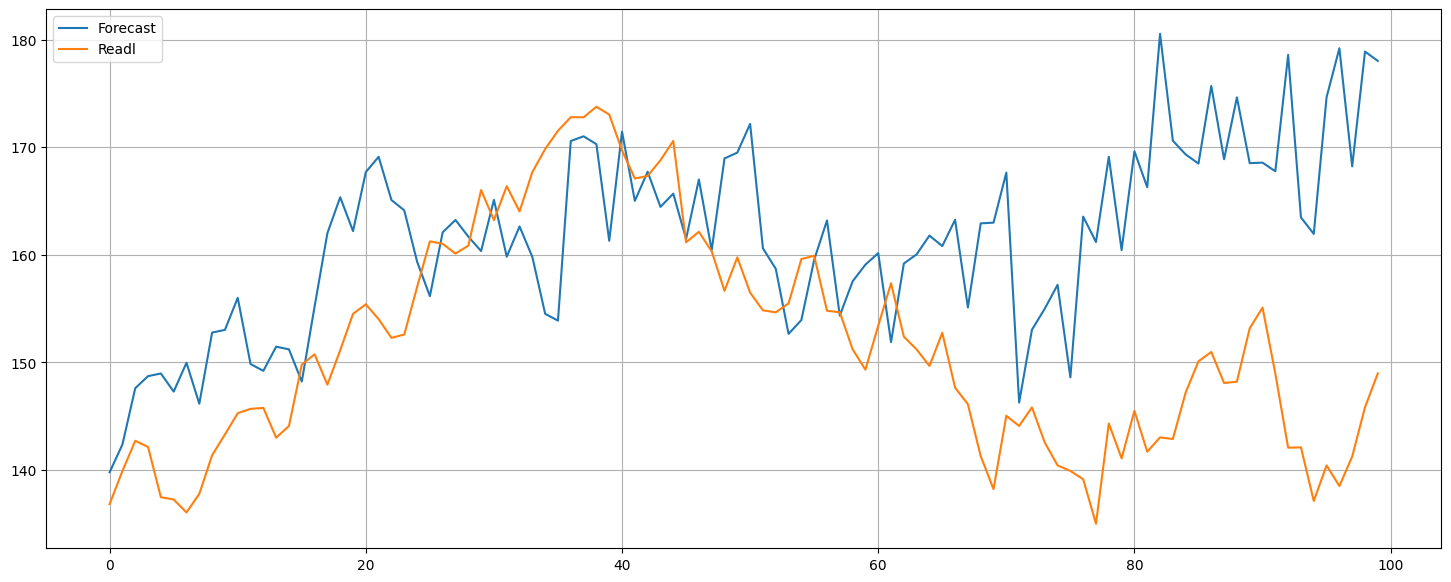

In [65]:
plt.figure(figsize= (18, 7))
plt.plot(forecasted, label= "Forecast")
plt.plot(x_test, label= "Readl")
plt.grid(True)
plt.legend(loc= "best")
plt.show()

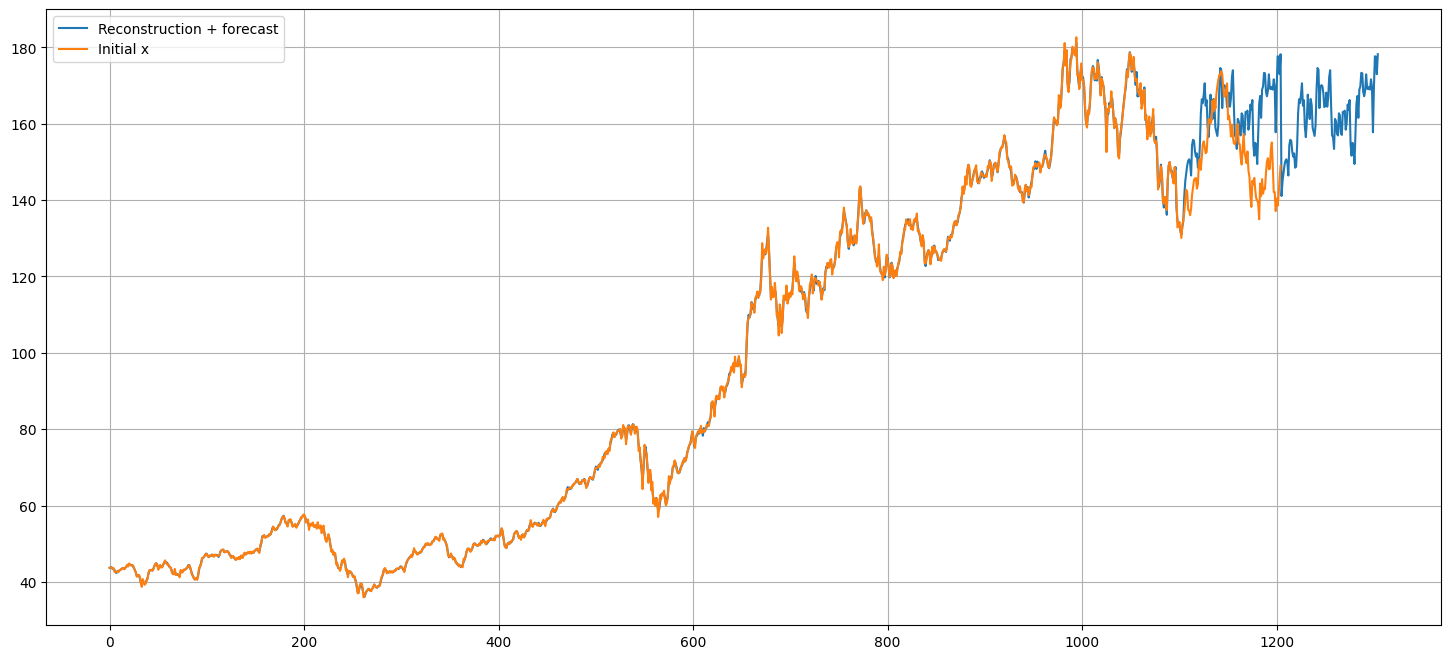

In [45]:
plt.figure(figsize= (18, 8))
plt.plot(np.concatenate([np.array(reconstructed_values[4500:]), forecasted], axis= 0), label= "Reconstruction + forecast")
plt.plot(np.arange(len(x[4500:])),x[4500:], label= "Initial x")
plt.legend(loc= "best")
plt.grid(True);

4523    2.81
4524    2.76
4525    2.69
4526    2.67
4527    2.54
4528    2.56
4529    2.52
4530    2.53
4531    2.52
4532    2.48
4533    2.57
4534    2.56
4535    2.63
4536    2.70
4537    2.62
4538    2.62
4539    2.78
4540    2.77
4541    2.53
4542    2.50
Name: Цена open, dtype: float64

# Теория SSA

In [3]:
L = 20
N = x.shape[0]
K = N - L + 1

X = np.zeros((L, K))
for i in range(L):
    X[i, :] = x[i: K + i]

X, X.shape

(array([[-91.99331979, -77.85287578, -70.23571688, ...,  -2.69074686,
          -2.69074686,  21.13539025],
        [-77.85287578, -70.23571688, -70.23571688, ...,  -2.69074686,
          21.13539025,  21.13539025],
        [-70.23571688, -70.23571688, -70.23571688, ...,  21.13539025,
          21.13539025,  26.07847811],
        ...,
        [-21.13539025, -21.13539025, -12.99813686, ...,  65.52945285,
          65.52945285,  70.23571688],
        [-21.13539025, -12.99813686,  27.83396365, ...,  65.52945285,
          70.23571688,  70.23571688],
        [-12.99813686,  27.83396365,  27.83396365, ...,  70.23571688,
          70.23571688,  91.99331979]]),
 (20, 460))

## SVD разложение

$${X_{n, m} = U \Sigma V^*}$$
${U_{n,n}}$ - по столбцам стоят нормированные собственные вектора матрицы `X.T @ X`
${V^*_{m,m}}$ - по строкам стоят нормированные собственные вектора матрицы `X @ X.T`
${\Sigma_{n,m}}$ - по диагонали стоят ${\sqrt{\lambda_j}: \overline{1,m}}$

In [4]:
U,S,Vt = np.linalg.svd(X)
V = Vt.T

d = np.linalg.matrix_rank(X)
X_elem = np.array([S[i] * np.outer(U[:, i], V[:, i]) for i in range(d)])
X_elem.shape

(20, 20, 460)

In [5]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

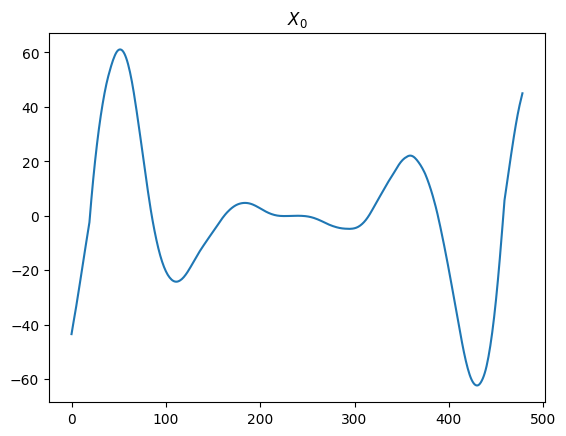

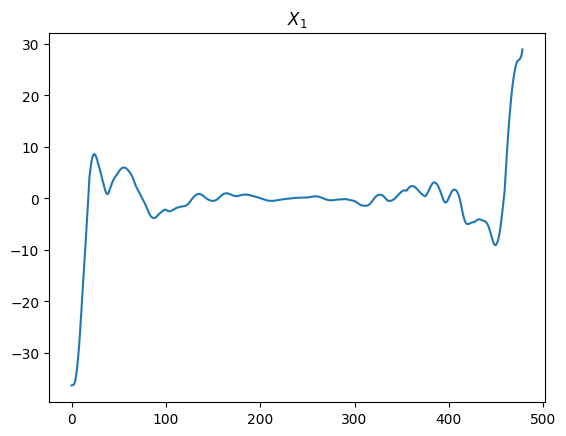

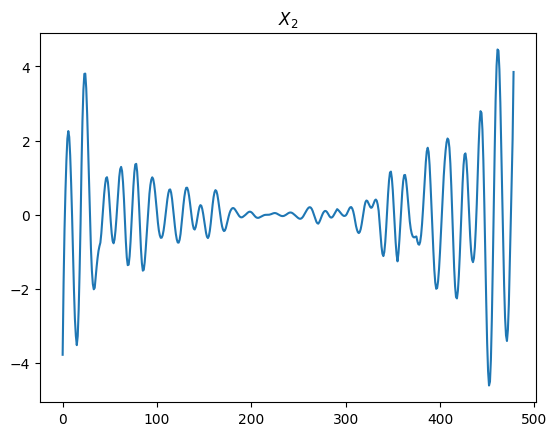

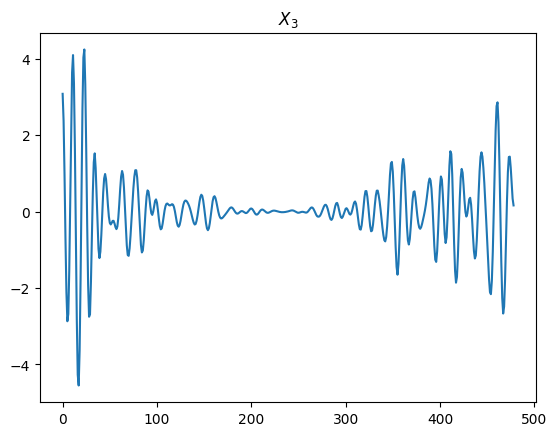

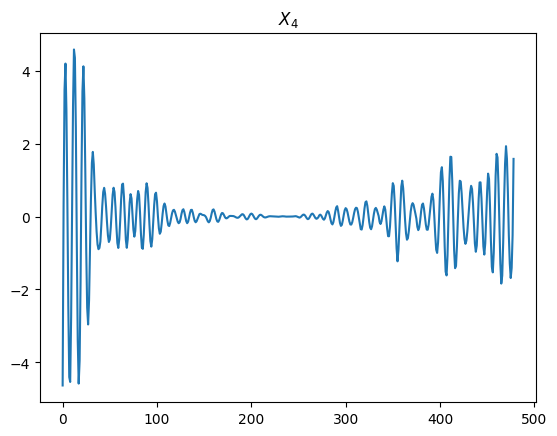

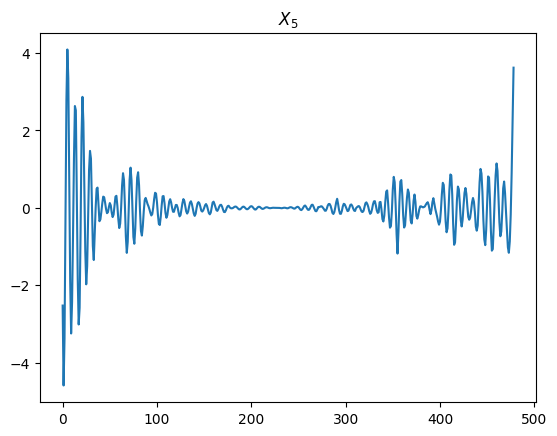

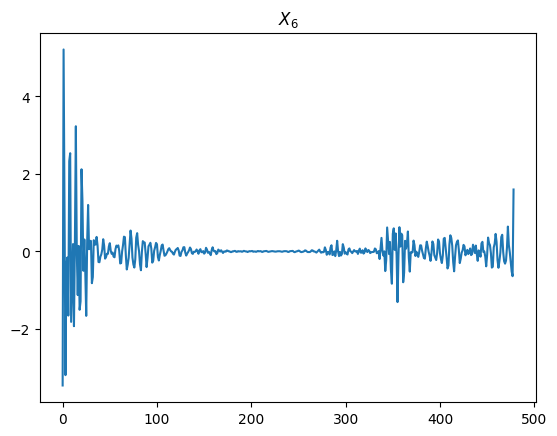

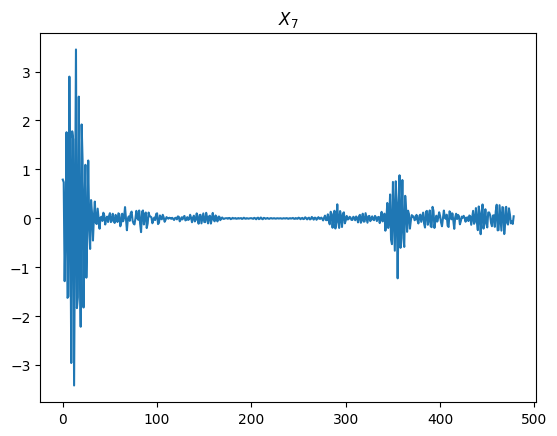

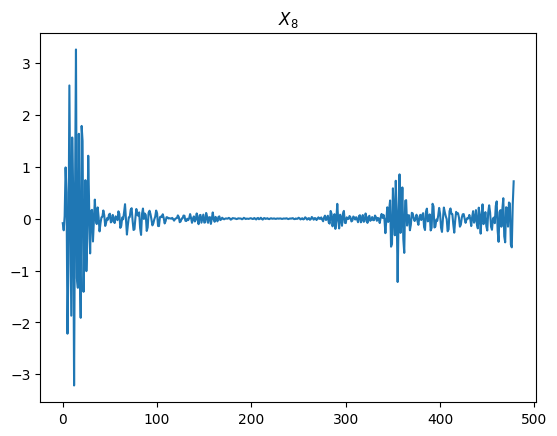

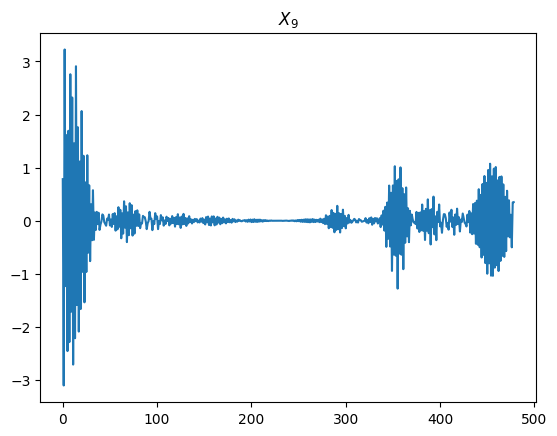

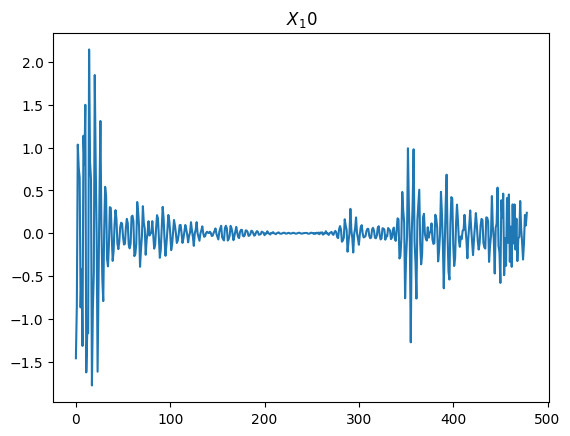

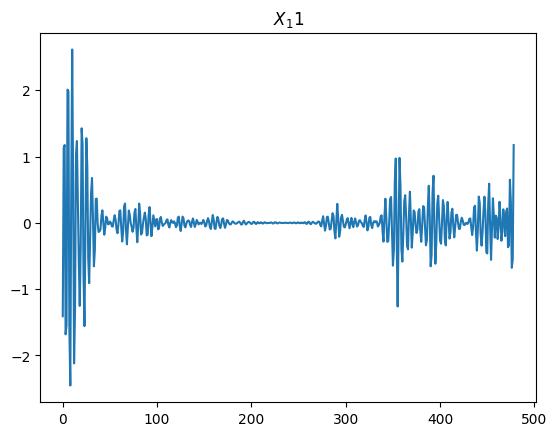

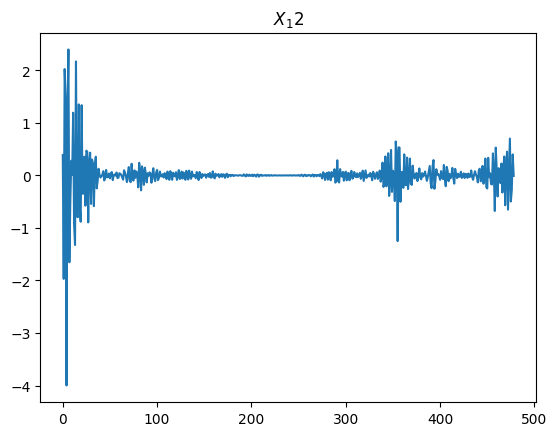

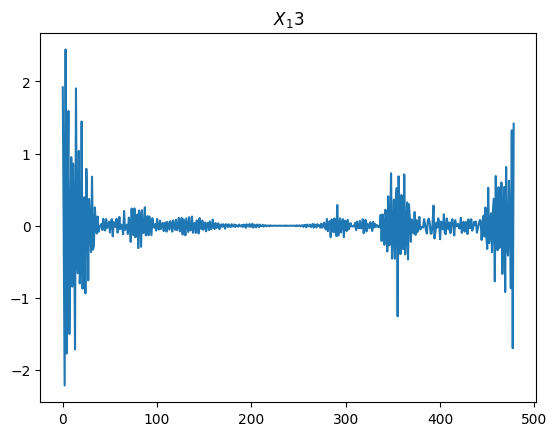

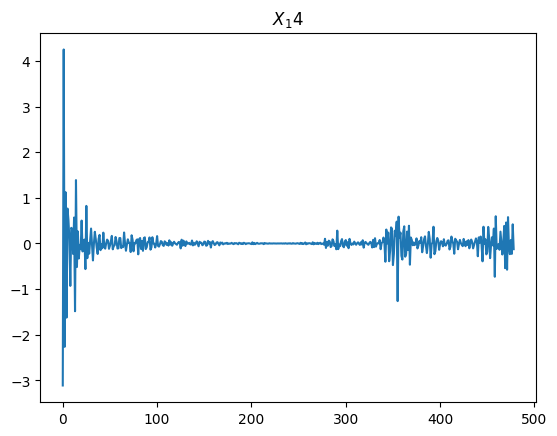

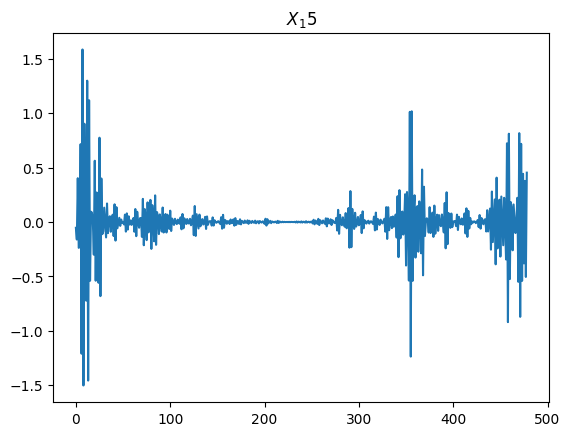

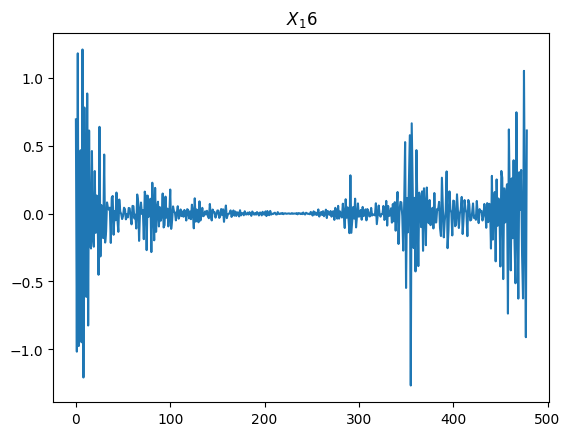

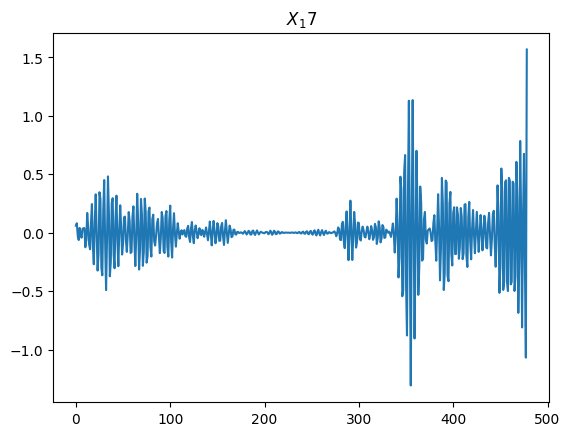

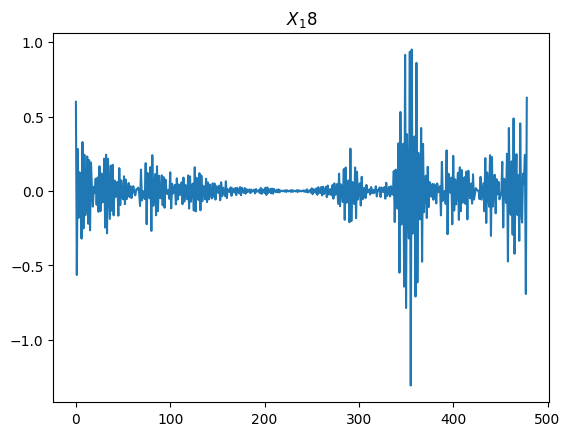

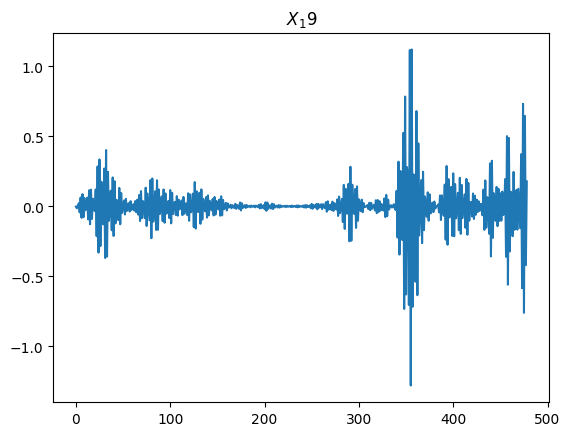

In [8]:
for i in range(X_elem.shape[0]):
    plt.plot(X_to_TS(X_elem[i]))
    plt.title(f"$X_{i}$")
    plt.show()

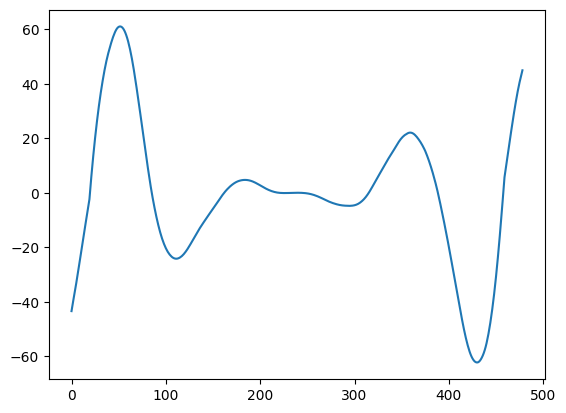

In [7]:
plt.plot(X_to_TS(X_elem[0]));

In [9]:
# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w),
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

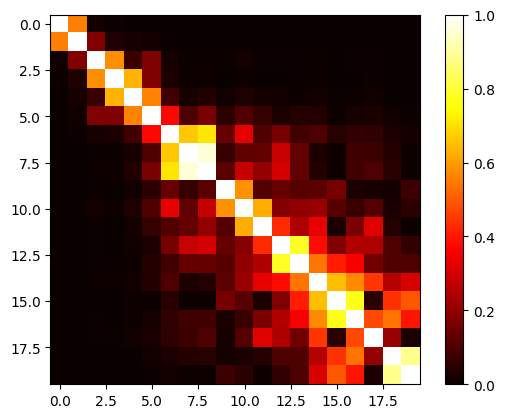

In [17]:
axs = plt.imshow(Wcorr)
# plt.figure(figsize= (18, 9))
plt.colorbar(axs.colorbar, fraction= 0.045)
plt.clim(0, 1)

In [19]:
class SSA(object):
    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)